## Sentinel SAR Floodwater Detection: EDA

<figure><center><img src="https://cdn.who.int/media/images/default-source/health-and-climate-change/rescue-operation-haiti-flood-c-un-photo-marco-dormino.tmb-1366v.jpg?sfvrsn=412ab270_4%201366w" width="400" height="40"></center></figure>

<p><center><i>Credit: UN Photo / Marco Dormino </i></center></p>

This project has taken on the task of detecting the presence of floodwater in Sentinel-1 global [synthetic aperture radar (SAR)](https://earthdata.nasa.gov/learn/backgrounders/what-is-sar) imagery. While traditional optical sensors measure reflected solar light, SAR operates in the microwave band of the electromagnetic spectrum. It is therefore uniquely positioned to provide a day-and-night supply of images of the Earth's surface through the coverage of clouds, smoke, vegetation, and precipitation. With the increasing prevalence of extreme weather events due to climate change, your machine learning models and insights have the potential to strengthen flood mapping algorithms and improve disaster risk management efforts around the world. 

The data consist of "chips" from flood events around the world, which each contain two polarization bands. Each chip has a corresponding label mask that indicates which pixels in a scene contain water. These will not be the same chips used in training of models, however they are similar and provide interesting metadata to explore!

Project and open source code taken from:
The benchmark solution tutorial from [Map Floodwater from Radar Imagery competition](https://www.drivendata.org/competitions/81/detect-flood-water/) in partnership with [Microsoft AI for Earth](https://www.microsoft.com/en-us/ai/ai-for-earth) and [Cloud to Street](https://www.cloudtostreet.ai/).

In [1]:
!pip install watermark

Defaulting to user installation because normal site-packages is not writeable


<a id="section1"></a>

In [ ]:
%load_ext watermark
%watermark -v

In [ ]:
%watermark -i

### Explore the Data

#### Metadata

First we'll download the data to a new subdirectory called `training_data/` in our current working directory. Path example: `/accounts/projects/binyu/user/flood_train_data`

```
$ tree training_data/
training_data/
├── flood-training-metadata.csv
├── train_features
│   ├── awc00_vh.tif
│   ├── awc00_vv.tif
        ...
│   ├── wvy31_vh.tif
│   └── wvy31_vv.tif
└── train_labels
    ├── awc00.tif
    ├── awc01.tif
        ...
    ├── wvy30.tif
    └── wvy31.tif

2 directories, 1627 files
```

To better understand what's in our data, we can begin by exploring trends across different locations and flood events. Let's load the metadata and look at what we have.

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# This is where our downloaded images and metadata live locally
DATA_PATH = Path("/accounts/projects/binyu/user/flood_train_data")
FEATURE_PATH = DATA_PATH / "train_features"
LABEL_PATH = DATA_PATH / "train_labels"

train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


The training data for this competition consist of two [polarization bands](https://nisar.jpl.nasa.gov/mission/get-to-know-sar/polarimetry/) that bring out distinct physical properties in a scene: VV (vertical transmit, vertical receive) and VH (vertical transmit, horizontal receive). Each band is identified by a unique `image_id`, which is equivalent to `{chip_id}_{polarization}`. A `chip_id` consists of a three letter `flood_id` and a two digit chip number. **Each unique chip has both a `_vv` and `_vh` band.** For example, `awc00_vh` represents the `vv` band of chip number `00` for flood `awc`.

In [4]:
train_metadata.shape

(1084, 6)

In [5]:
train_metadata.chip_id.nunique()

542

Let's take a look at how many flood events are in the training data and how many chips we have per event.

In [6]:
flood_counts = train_metadata.groupby("flood_id")["chip_id"].nunique()
flood_counts.describe()

count    13.000000
mean     41.692308
std      19.947367
min      15.000000
25%      28.000000
50%      32.000000
75%      65.000000
max      69.000000
Name: chip_id, dtype: float64

The data includes chips from 13 flood events. We have anywhere from 15 to 69 chips (30 to 138 images) per unique event, with half of events containing fewer than 32 chips (64 images).

We can also take a look at the distribution of chips by location.

Text(0, 0.5, 'Number of Images')

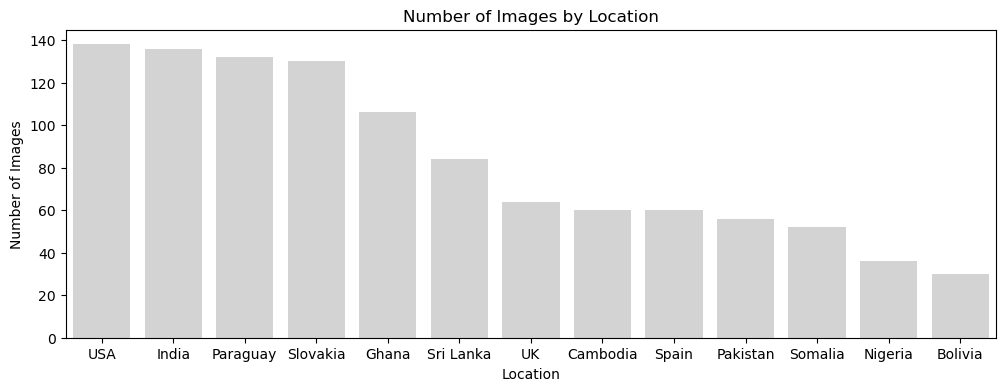

In [33]:
import seaborn as sns

plt.figure(figsize=(12, 4))
sns.countplot(
    x=train_metadata.location,
    order=train_metadata.location.value_counts().index,
    color="lightgray",
)
plt.title("Number of Images by Location")
plt.xlabel("Location")
plt.ylabel("Number of Images")

The data cover a wide geographic range. We have more than 60 chips (120 images) for floods in the United States, India, Paraguay, and Slovakia.

Lets take a look at the distribution of chips by date. This is important to consider as we don't want our data to be clustered around a single period of time!

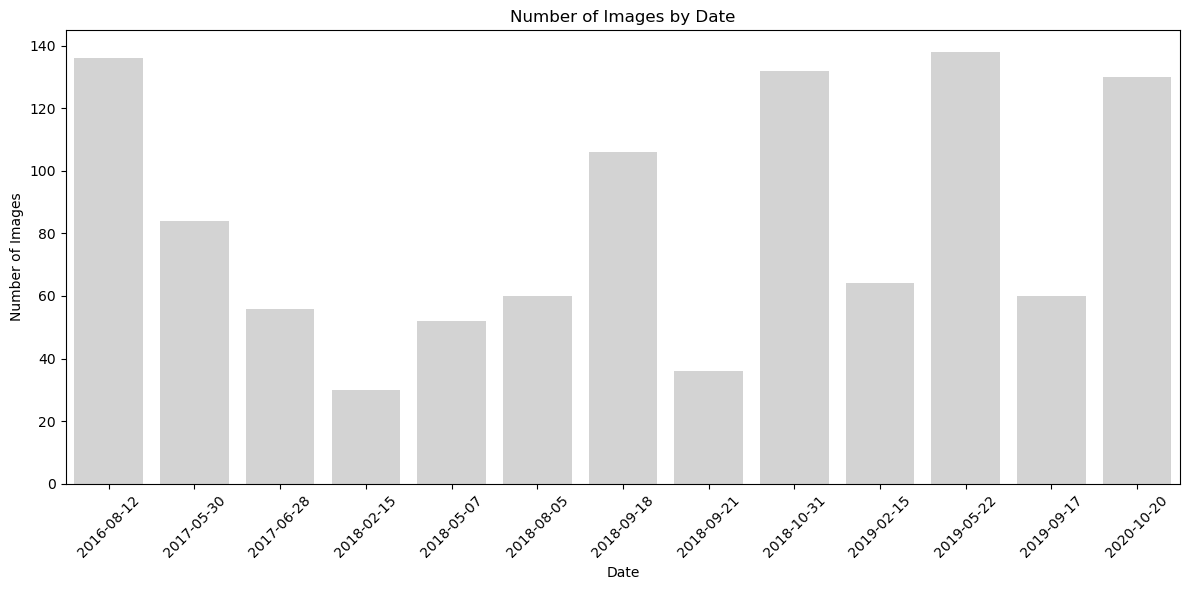

In [34]:
train_metadata['scene_start'] = pd.to_datetime(train_metadata['scene_start'])
train_metadata['scene_date'] = train_metadata['scene_start'].dt.date

# Sort the unique dates
sorted_dates = sorted(train_metadata['scene_date'].unique())

plt.figure(figsize=(12, 6))
sns.countplot(
    x=train_metadata['scene_start'].dt.date,
    order=sorted_dates,
    color="lightgray",
)
plt.title("Number of Images by Date")
plt.xlabel("Date")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

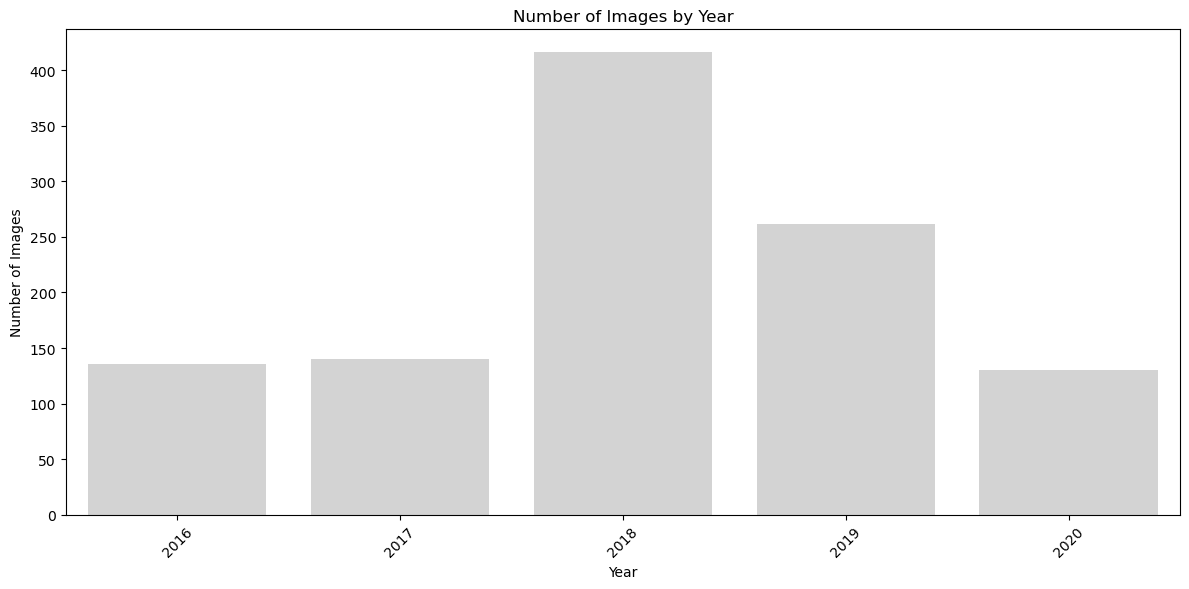

In [41]:
train_metadata['scene_start'] = pd.to_datetime(train_metadata['scene_start'])
train_metadata['scene_year'] = train_metadata['scene_start'].dt.year
sorted_years = sorted(train_metadata['scene_year'].unique())

plt.figure(figsize=(12, 6))
sns.countplot(
    x=train_metadata['scene_year'],
    order=sorted_years,
    color="lightgray",
)
plt.title("Number of Images by Year")
plt.xlabel("Year")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

Looks like most of our data was collected in 2018, this is important to note.

Let's also take a look at when the images were originally captured.

In [9]:
year = train_metadata.scene_start.dt.year
year_counts = train_metadata.groupby(year)["flood_id"].nunique()
year_counts

scene_start
2016    1
2017    2
2018    6
2019    3
2020    1
Name: flood_id, dtype: int64

In [10]:
train_metadata.groupby("flood_id")["scene_start"].nunique()

flood_id
awc    1
ayt    1
coz    1
hbe    1
hxu    1
jja    1
kuo    1
pxs    1
qus    1
qxb    1
tht    1
tnp    1
wvy    1
Name: scene_start, dtype: int64

The data cover flood events that occurred between 2016 and 2020. Images for each event were captured on the same day.

#### Images

<figure><center><img src="https://www.researchgate.net/profile/Tom-Rune-Lauknes/publication/50280789/figure/fig1/AS:644621013098497@1530701034005/Simplified-geometry-of-a-synthetic-aperture-radar-SAR-system.png" width="400" height="40"></center></figure>

Next, we can begin exploring the image data!

A GeoTIFF is a raster image file that contains geographic metadata describing the location of the image. This metadata can include bounding coordinates, an affine transform, and a coordinate reference system (CRS) projection. The package [rasterio](https://rasterio.readthedocs.io/en/latest/) makes it easy to interact with our geospatial raster data.

**Recall that each set of two polarizations (vh and vh) correspond with a single water label.**

In [11]:
import rasterio

# Examine an arbitrary image
image_path = FEATURE_PATH / f"{train_metadata.image_id[0]}.tif"

with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)  # read a single band

metadata

ERROR 1: PROJ: proj_identify: /usr/local/linux/mambaforge-3.11/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 20S",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-63],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(10.0, 0.0, 314030.0,
        0.0, -10.0, 8585890.0)}

In [13]:
bounds

BoundingBox(left=314030.0, bottom=8580770.0, right=319150.0, top=8585890.0)

In [14]:
data

array([[-16.208015 , -17.71951  , -16.281353 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.3288965, -18.231857 , -16.451893 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.353134 , -16.88831  , -15.585904 , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [-15.741662 , -15.230668 , -13.455255 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.498258 , -14.100984 , -13.11027  , ...,   0.       ,
          0.       ,   0.       ],
       [-16.055603 , -14.1121   , -14.76084  , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)

We will need to be able to identify pixels with missing data, since we will only be evaluated on predictions made for valid input pixels. The metadata tells us that a value of 0.0 represents missing data for an input image. In `rasterio`, you can access two different kinds of missing data masks. The first mask is a [GDAL-style](https://gdal.org/) mask, in which non-zero elements (typically 255) indicate that the corresponding data elements are valid.

In [15]:
with rasterio.open(image_path) as img:
    gdal_mask = img.dataset_mask()

gdal_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

The second mask is a [numpy masked array](http://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html), which has the inverse sense: `True` values indicate that the corresponding data elements are invalid. To load the data as a numpy masked array and access this type of missing data mask, simply pass a `masked` flag to `read`.

In [16]:
with rasterio.open(image_path) as img:
    numpy_mask = img.read(1, masked=True)

numpy_mask

masked_array(
  data=[[-16.20801544189453, -17.71950912475586, -16.281352996826172,
         ..., --, --, --],
        [-15.328896522521973, -18.231857299804688, -16.451892852783203,
         ..., --, --, --],
        [-15.353134155273438, -16.888309478759766, -15.585904121398926,
         ..., --, --, --],
        ...,
        [-15.74166202545166, -15.230668067932129, -13.455254554748535,
         ..., --, --, --],
        [-15.498257637023926, -14.100983619689941, -13.110269546508789,
         ..., --, --, --],
        [-16.05560302734375, -14.112099647521973, -14.76084041595459,
         ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=f

Pixel values represent energy that was reflected back to the satellite measured in decibels. To better visualize the bands or channels of Sentinel-1 images, we will create a [false color composite](https://earthobservatory.nasa.gov/features/FalseColor) by treating the two bands and their ratio as red, grean, and blue channels, respectively. We will prepare a few helper functions to visualize the data.

In [17]:
import warnings

warnings.filterwarnings("ignore")

# Helper functions for visualizing Sentinel-1 images


def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]

    # Extract paths to image files
    vv_path = FEATURE_PATH / f"{random_chip}_vv.tif"
    vh_path = FEATURE_PATH / f"{random_chip}_vh.tif"
    label_path = LABEL_PATH / f"{random_chip}.tif"

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

Let's inspect a few chips and their water labels.

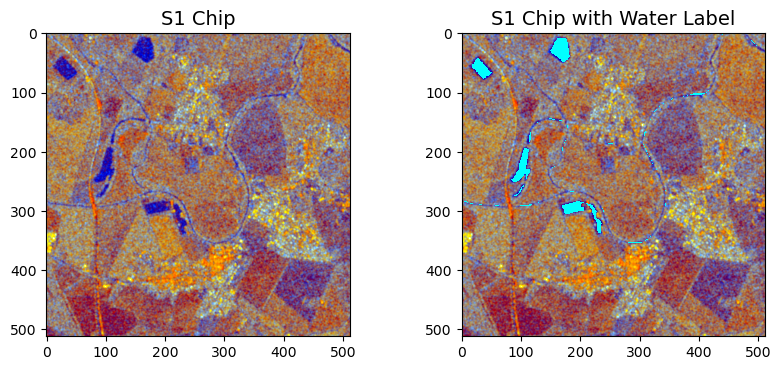

In [18]:
display_random_chip(7)

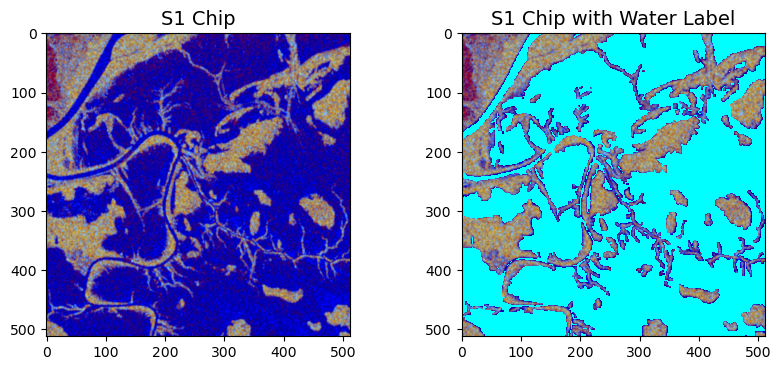

In [19]:
display_random_chip(66)

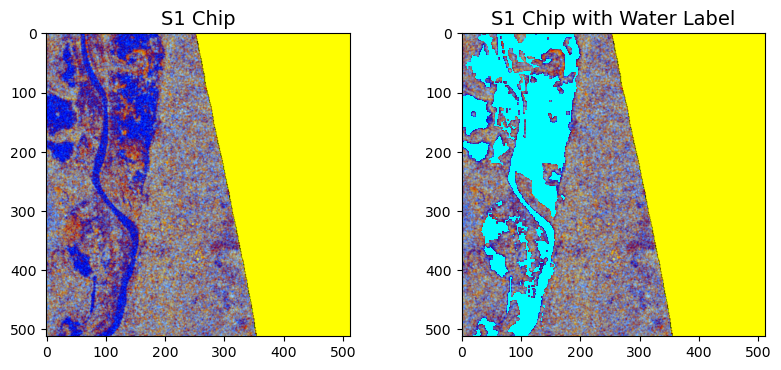

In [20]:
display_random_chip(90)

Pretty interesting!

You'll notice that some images contain high floodwater coverage, while others have little to no coverage. Water spread may be concentrated in one location or spread out, depending on a variety of surface characteristics like topography, terrain, and ground cover. Missing pixels are displayed in yellow.

Finally, let's confirm that the first few images are the expected size of 512 x 512 pixels.

In [21]:
imgs = [FEATURE_PATH / f"{train_metadata.image_id[x]}.tif" for x in range(5)]
for img in imgs:
    print(rasterio.open(img).shape)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
